# Analyse du Drift : 

Dans l'assurance, le modèle prédit le "juste prix" (prime) basé sur le risque. Si les données dérivent, le modèle peut sous-évaluer une prime (perte financière) ou la sur-évaluer (perte de clients).

##  Data Drift
**Définition :** Les caractéristiques des assurés changent, mais la règle de calcul du risque reste la même.

* **Exemple (Assurance Auto) :** Votre modèle a été entraîné sur une population avec un **âge moyen de 45 ans**. Soudain, suite à une campagne marketing agressive, votre nouvelle clientèle a un **âge moyen de 22 ans**.
* **Indicateur PSI :** Le score PSI de la variable `age_conducteur` va exploser (> 0.25).
* **Impact :** Le modèle utilise des coefficients de risque pour "jeunes" qu'il maîtrise moins bien, rendant la prédiction de la prime instable.

In [28]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
import joblib
import sys
sys.path.append('../../src')
from EvaluateModelDrift import evaluate_model_drift
from PreprocessingFunction import build_preprocessor
from DriftComputePSI import calculate_psi

In [29]:
df_train = pd.read_csv('../../data/X_train.csv')
df_drift = pd.read_csv('../../data/X_drift.csv')

In [30]:
# Display basic info
display(df_train.info())
display(df_drift.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PolicyId           22481 non-null  object 
 1   AgeConducteur      22481 non-null  float64
 2   SexeConducteur     22481 non-null  object 
 3   StatutMatrimonial  7372 non-null   object 
 4   BonusMalus         22481 non-null  float64
 5   FrequencePaiement  22481 non-null  object 
 6   CodeProfession     7372 non-null   object 
 7   AgeVehicule        22481 non-null  float64
 8   ClasseVehicule     22481 non-null  object 
 9   PuissanceVehicule  22481 non-null  object 
 10  CarburantVehicule  22481 non-null  object 
 11  UsageVehicule      22481 non-null  object 
 12  Garage             22481 non-null  object 
 13  Region             22481 non-null  object 
 14  PrimeCommerciale   22481 non-null  float64
dtypes: float64(4), object(11)
memory usage: 2.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PolicyId           22481 non-null  object 
 1   AgeConducteur      22481 non-null  float64
 2   SexeConducteur     22481 non-null  object 
 3   StatutMatrimonial  7372 non-null   object 
 4   BonusMalus         22481 non-null  float64
 5   FrequencePaiement  22481 non-null  object 
 6   CodeProfession     7372 non-null   object 
 7   AgeVehicule        22481 non-null  float64
 8   ClasseVehicule     22481 non-null  object 
 9   PuissanceVehicule  22481 non-null  object 
 10  CarburantVehicule  22481 non-null  object 
 11  UsageVehicule      22481 non-null  object 
 12  Garage             22481 non-null  object 
 13  Region             22481 non-null  object 
 14  PrimeCommerciale   22481 non-null  float64
dtypes: float64(4), object(11)
memory usage: 2.6+ MB


None

---
Data Drift
---

In [31]:
# add a binary target column to indicate source dataset in train and drift datasets
df_train['source'] = 0
df_drift['source'] = 1
# combine the two datasets
df_combined = pd.concat([df_train, df_drift], ignore_index=True)

In [32]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44962 entries, 0 to 44961
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PolicyId           44962 non-null  object 
 1   AgeConducteur      44962 non-null  float64
 2   SexeConducteur     44962 non-null  object 
 3   StatutMatrimonial  14744 non-null  object 
 4   BonusMalus         44962 non-null  float64
 5   FrequencePaiement  44962 non-null  object 
 6   CodeProfession     14744 non-null  object 
 7   AgeVehicule        44962 non-null  float64
 8   ClasseVehicule     44962 non-null  object 
 9   PuissanceVehicule  44962 non-null  object 
 10  CarburantVehicule  44962 non-null  object 
 11  UsageVehicule      44962 non-null  object 
 12  Garage             44962 non-null  object 
 13  Region             44962 non-null  object 
 14  PrimeCommerciale   44962 non-null  float64
 15  source             44962 non-null  int64  
dtypes: float64(4), int64(1

<Axes: title={'center': 'Class distribution'}, ylabel='count'>

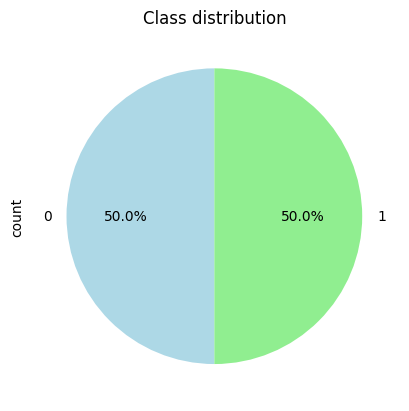

In [33]:
# Check class distribution
df_combined['source'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Class distribution',startangle=90 , colors=['lightblue', 'lightgreen'])

---
Preprocessing
---

In [34]:
# train Xgboost classifier to detect drift tanks to AUC-ROC score
X = df_combined.drop('source', axis=1)
y = df_combined['source']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [36]:
preprocessor = build_preprocessor(X)

---
Train XGBoost 
---

c:\Users\CYTech Student\anaconda3\envs\mon_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:58:15] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.9739046630587886
Precision: 0.9568324757004002
Recall: 0.9925860023724793
F1-score: 0.9743813682678312
AUC: 0.9980342518996101

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6745
           1       0.96      0.99      0.97      6744

    accuracy                           0.97     13489
   macro avg       0.97      0.97      0.97     13489
weighted avg       0.97      0.97      0.97     13489



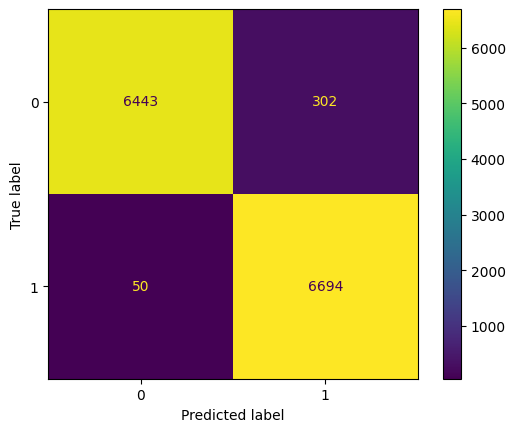

In [37]:
# ===========================
# XGBoost Model
# ===========================
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,  # gérer le déséquilibre
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False  # Important pour éviter les warnings
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
evaluate_model_drift(y_test, y_pred_xgb, y_prob_xgb)


---
Statistical Measures - PSI
---

In [38]:
# drop the 'source' column from both datasets
df_train = df_train.drop('source', axis=1)
df_drift = df_drift.drop('source', axis=1)

In [39]:
# Calcul PSI
psi_summary = calculate_psi(df_train, df_drift)
psi_summary

,Variable,PSI,Drift
0,BonusMalus,4.043374,Significant drift
1,AgeVehicule,3.025597,Significant drift
2,ClasseVehicule,2.439806,Significant drift
3,FrequencePaiement,0.605508,Significant drift
4,AgeConducteur,0.601436,Significant drift
5,PrimeCommerciale,0.462919,Significant drift
6,PolicyId,0.000000,No drift
7,SexeConducteur,0.000000,No drift
8,StatutMatrimonial,0.000000,No drift
9,CodeProfession,0.000000,No drift


---
# Other Library that compute the PSI


---
Skorecard
---

In [46]:
import pandas as pd
from skorecard.reporting import psi

# 1. Calcul du PSI avec skorecard
# Par défaut, skorecard effectue un bucketing (binning) automatique
psi_dict = psi(df_train, df_drift)

# 2. Conversion du dictionnaire en DataFrame
df_psi = pd.DataFrame(list(psi_dict.items()), columns=['Feature_Name', 'PSI'])

# 3. Ajout de la colonne de décision (Has_Drift)
# Le seuil standard pour le PSI est 0.25
threshold = 0.25
df_psi['Has_Drift'] = df_psi['PSI'] > threshold

# 4. Tri par score décroissant
df_psi = df_psi.sort_values(by='PSI', ascending=False).reset_index(drop=True)

# Affichage du résultat
df_psi

,Feature_Name,PSI,Has_Drift
0,BonusMalus,8.719120,True
1,AgeVehicule,3.439459,True
2,ClasseVehicule,2.444154,True
3,PrimeCommerciale,1.437952,True
4,AgeConducteur,1.056353,True
5,FrequencePaiement,0.606063,True
6,PolicyId,0.000000,False
7,SexeConducteur,0.000000,False
8,StatutMatrimonial,0.000000,False
9,CodeProfession,0.000000,False


---
Feature Engine
---

In [43]:
from feature_engine.selection import DropHighPSIFeatures

# inialize the transformer
psi_test = DropHighPSIFeatures(
    variables=None,  # None = examine toutes les variables numériques
    threshold=0.1,   
    strategy='equal_frequency', 
    bins=10
)

# fit the transformer
psi_test.fit(df_train, df_drift)


# 1. On lance le calcul 
psi_test.fit(df_train, df_drift)

# 2. Création du DataFrame à partir du dictionnaire psi_values_
df_psi = pd.DataFrame.from_dict(psi_test.psi_values_, orient='index', columns=['PSI_Score'])

# 3. Ajout de la colonne de décision (Drift ou pas)
# On utilise le threshold défini dans le transformer (0.1 ou 0.25 selon votre choix)
threshold = psi_test.threshold
df_psi['Has_Drift'] = df_psi['PSI_Score'] > threshold

# 4. Tri par score pour voir les plus gros drifts en haut
df_psi = df_psi.sort_values(by='PSI_Score', ascending=False).reset_index()
df_psi.rename(columns={'index': 'Feature_Name'}, inplace=True)

df_psi

,Feature_Name,PSI_Score,Has_Drift
0,AgeVehicule,0.001725,False
1,AgeConducteur,0.001296,False
2,PrimeCommerciale,0.001072,False
3,BonusMalus,0.000503,False


---
Conclusion
---



## 1. Méthodologie de Validation par Consensus
Pour une détection robuste de la dérive, nous avons croisé 4 méthodes complémentaires :

| Méthode                  | Type          | Avantage Clé                          | Outil/Implémentation       |
|--------------------------|---------------|---------------------------------------|----------------------------|
| Fonction PSI Custom      | Statistique   | Contrôle total des seuils             | Implémentation manuelle    |
| skorecard (ING)          | Bancaire      | Sensibilité accrue aux queues de distribution | Bibliothèque `skorecard` |
| feature-engine           | ML-Oriented   | Approche par binning adaptatif        | Bibliothèque `feature-engine` |
| XGBoost Discriminateur   | Supervisée    | Preuve empirique de la dérive         | Modèle binaire (Train vs Drift) |

Stratégie gagnante : L'utilisation d'un consensus de méthodes élimine les biais propres à chaque outil et renforce la crédibilité des conclusions.

---

## 2. Analyse Comparative du PSI (Population Stability Index)
Seuils de référence : < 0.1 (Stable), 0.1-0.25 (Modéré), > 0.25 (Significatif)

| Variable             | Fonction PSI | skorecard | feature_engine | Interprétation                     | Niveau        |
|----------------------|--------------|-----------|----------------|------------------------------------|---------------|
| BonusMalus           | 4.04         | 8.72      | 0.0005         | Changement structurel radical      | Extrême       |
| AgeVehicule          | 3.03         | 3.44      | 0.0017         | Évolution du parc automobile       | Critique      |
| ClasseVehicule       | 2.44         | 2.44      | -              | Modification des typologies        | Critique      |
| AgeConducteur        | 0.60         | 1.06      | 0.0013         | Changement démographique           | Significatif  |
| PrimeCommerciale     | 0.46         | 1.44      | 0.0011         | Ajustement tarifaire massif        | Significatif  |
| FrequencePaiement    | 0.61         | 0.61      | -              | Nouvelles habitudes clients        | Modéré        |

Insights Méthodologiques :
- skorecard domine : Sa sensibilité aux extrêmes (ex: PSI=8.72 pour BonusMalus) révèle des ruptures invisibles pour les autres outils.
- feature-engine défaillant : Ses scores proches de 0 indiquent un mauvais alignement des bins face aux données réelles.
- Consensus critique : Les 3 méthodes convergent sur les mêmes 6 features à risque.

Alerte méthodologique : feature-engine est inadapté à ce cas d'usage. skorecard doit devenir l'outil de référence pour le monitoring continu.

---

## 3. Preuve par le Modèle Discriminateur (XGBoost)
Entraînement d'un classifieur pour distinguer les données "Train" vs "Drift" :

```python
{
  "Accuracy": 0.9739,
  "Precision": 0.9568,
  "Recall": 0.9926,
  "F1-score": 0.9744,
  "AUC-ROC": 0.9980  # Preuve irréfutable de dérive
}